In [2]:
from tpe.optimizer import TPEOptimizer
import numpy as np
import matplotlib.pyplot as plt
import os
from tpe.utils.benchmarks import (
    Ackley,
    DifferentPower,
    Griewank,
    Perm,
    KTablet,
    Levy,
    Rastrigin,
    Rosenbrock,
    Schwefel,
    Sphere,
    Styblinski,
    WeightedSphere,
    XinSheYang,
)
from typing import Dict
from tpe.utils.constants import WeightFuncs, QuantileFunc
import ConfigSpace as CS

os.makedirs("figs/", exist_ok=True)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 24
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

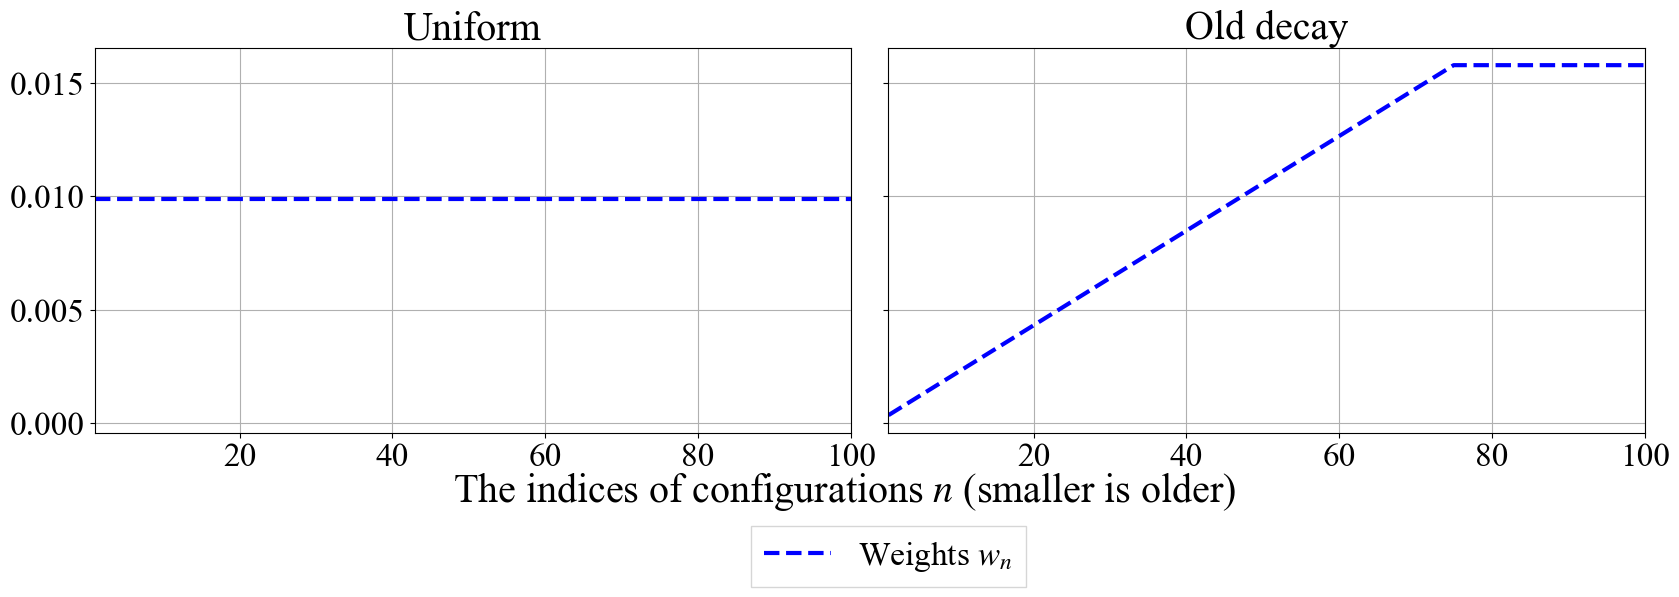

In [3]:
from tpe.utils.constants import WeightFuncs


fig, axes = plt.subplots(
    ncols=2,
    sharey=True,
    figsize=(20, 5),
    gridspec_kw=dict(
        wspace=0.05,
    )
)
n_samples = 100
T = np.arange(n_samples) + 1

ax = axes[0]
ax.set_title("Uniform")
wf = WeightFuncs("uniform")
ws = wf(n_samples, order=T - 1, sorted_loss_vals=T, prior=True)[:-1]
ax.plot(T, ws, color="blue", linestyle="dashed", lw=3)
ax.grid()
ax.set_xlim(1, n_samples)

ax = axes[1]
ax.set_title("Old decay")
wf = WeightFuncs("older-smaller")
ws = wf(n_samples, order=T - 1, sorted_loss_vals=T, prior=True)[:-1]
line, = ax.plot(T, ws, color="blue", linestyle="dashed", lw=3)
ax.grid()
ax.set_xlim(1, n_samples)

ax.legend(
    handles=[line],
    labels=["Weights $w_n$"],
    ncol=1,
    loc="upper center",
    bbox_to_anchor=(0.0, -0.2),
    fancybox=False,
    shadow=False,
)

fig.supxlabel(
    "The indices of configurations $n$ (smaller is older)",
    y=-0.05
)

plt.savefig("figs/weight-distribution.pdf", bbox_inches="tight")

In [4]:
target = Styblinski
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
Z = np.log(Z)
R = 5
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb


config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))

fixed_kwargs = dict(
    obj_func=target.func,
    config_space=config_space,
    seed=0,
)

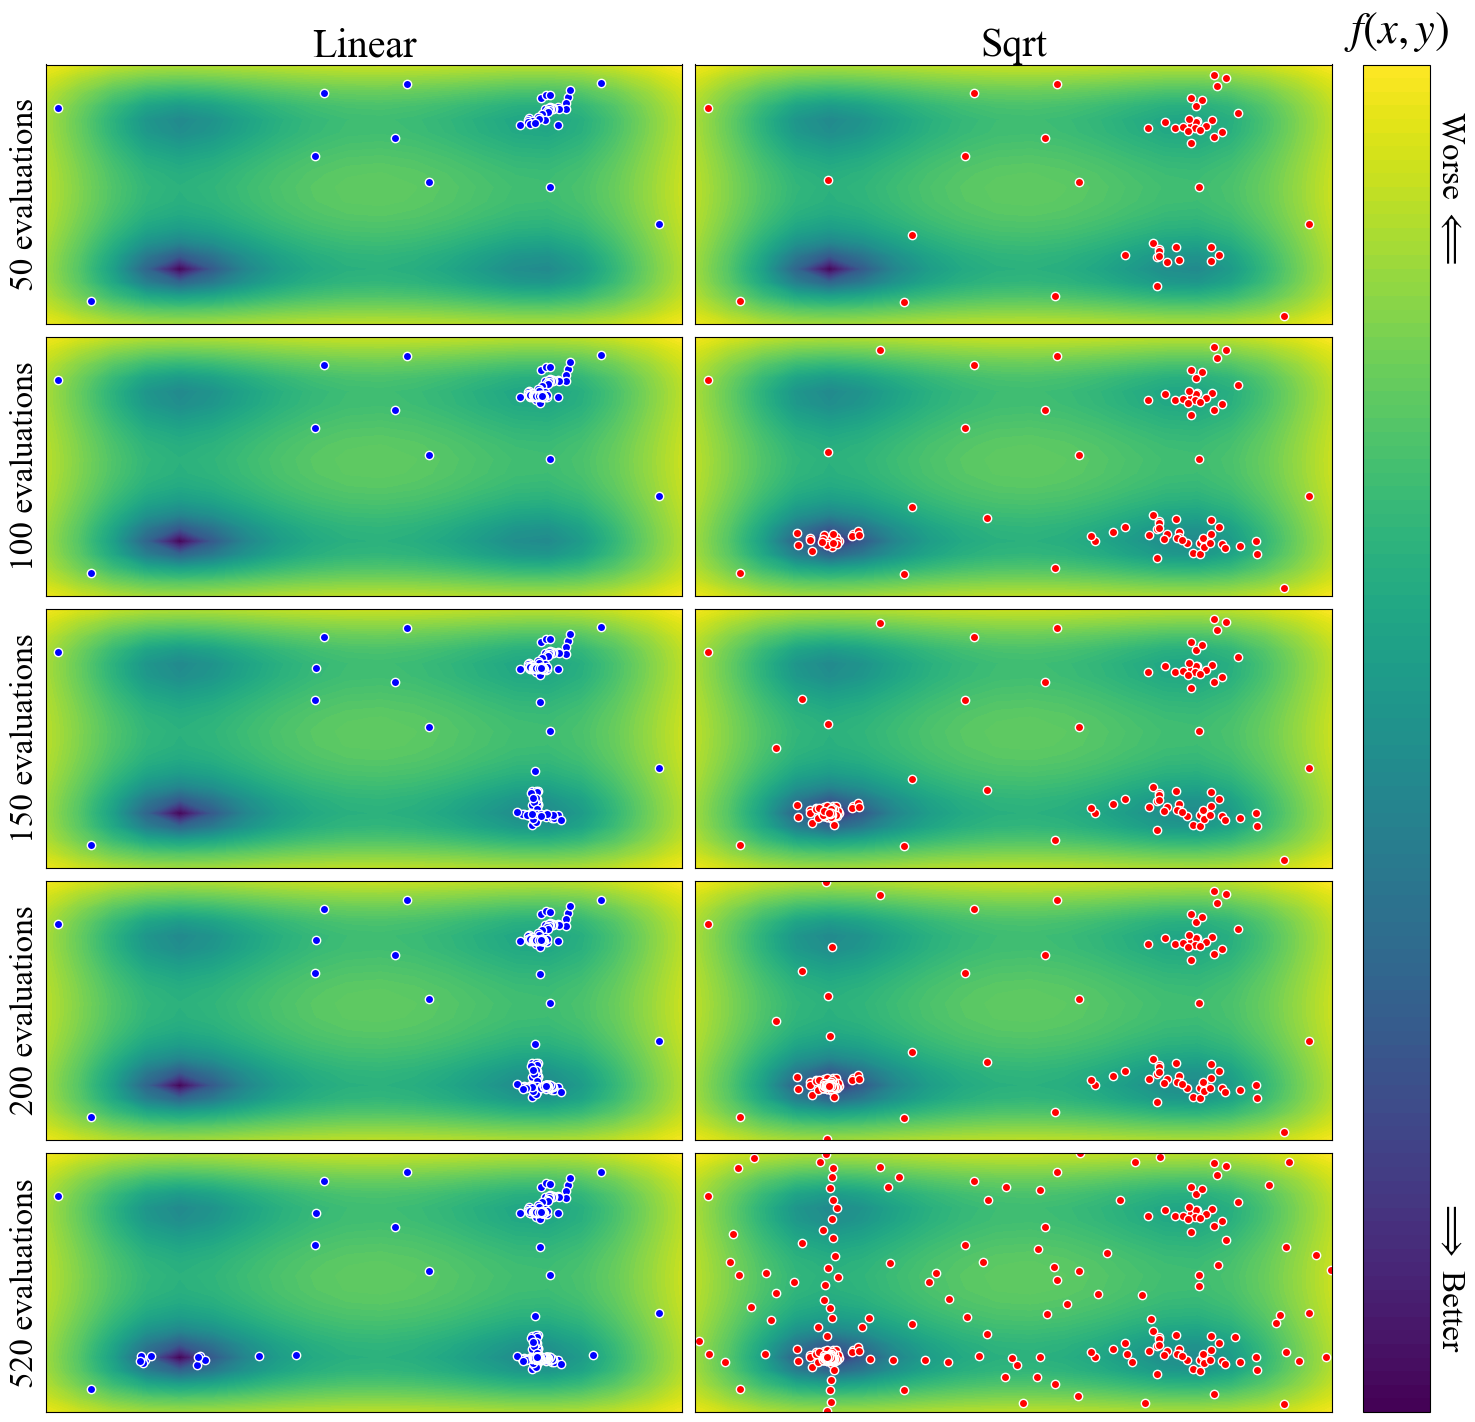

In [5]:
max_evals = 520
nrows = 5
fig, axes = plt.subplots(
    ncols=2,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
opt_sqrt = TPEOptimizer(
    quantile_func=QuantileFunc(choice="sqrt", alpha=0.25),
    max_evals=max_evals,
    **fixed_kwargs,
)
opt_sqrt.optimize()
opt_linear = TPEOptimizer(
    quantile_func=QuantileFunc(choice="linear", alpha=0.15),
    max_evals=max_evals,
    **fixed_kwargs,
)
opt_linear.optimize()

for r in range(nrows):
    n_evals = 50 * (r + 1) if r != nrows - 1 else max_evals
    ax = axes[r][0]
    if r == 0:
        ax.set_title("Linear")

    plot_func(ax)
    results_linear = opt_linear.fetch_observations()
    ax.scatter(results_linear["x"][:n_evals] * R, results_linear["y"][:n_evals] * R, color="blue", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Sqrt")
    cb = plot_func(ax)
    results_sqrt = opt_sqrt.fetch_observations()
    ax.scatter(results_sqrt["x"][:n_evals] * R, results_sqrt["y"][:n_evals] * R, color="red", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/exploration-by-gamma-in-styblinski.pdf", bbox_inches="tight")

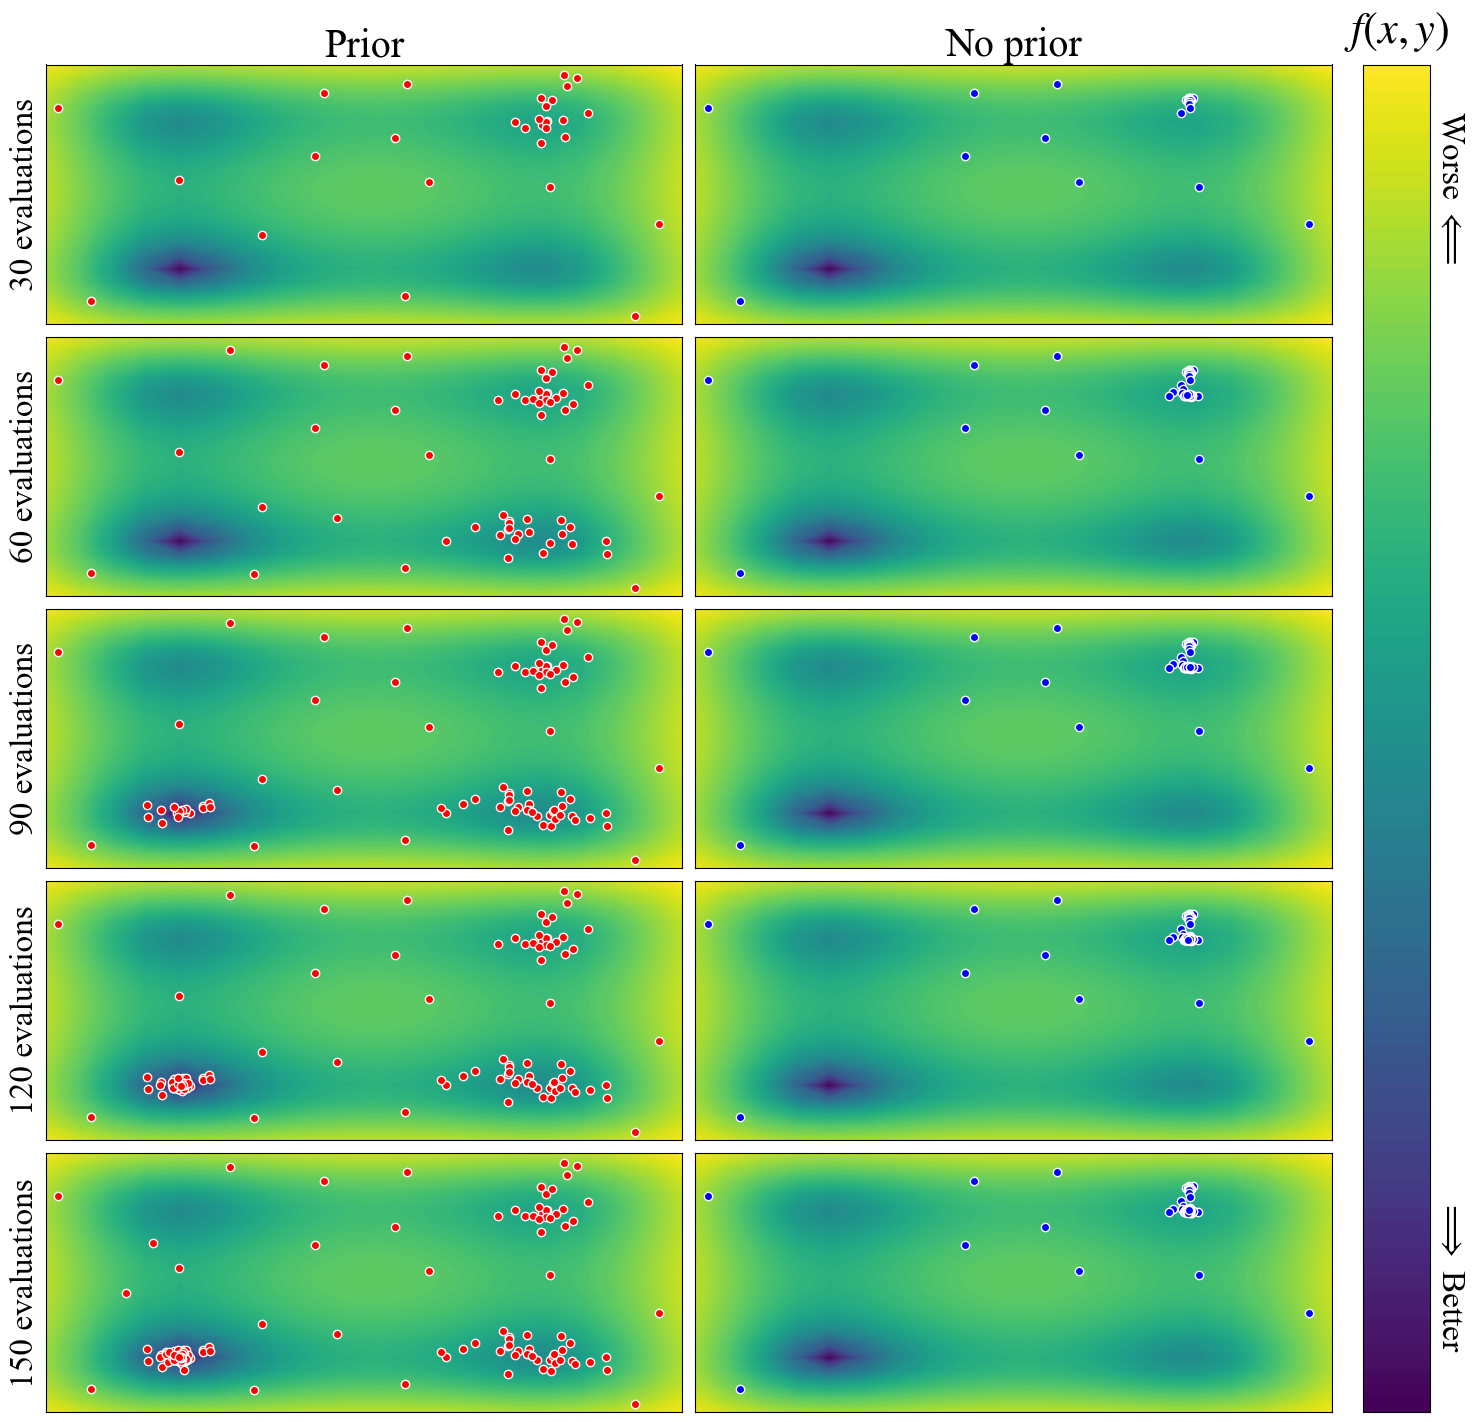

In [6]:
max_evals = 150

nrows = 5
fig, axes = plt.subplots(
    ncols=2,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)
opt_prior = TPEOptimizer(
    max_evals=max_evals,
    prior=True,
    **fixed_kwargs,
)
opt_prior.optimize()
opt_noprior = TPEOptimizer(
    max_evals=max_evals,
    prior=False,
    **fixed_kwargs,
)
opt_noprior.optimize()

for r in range(nrows):
    n_evals = 30 * (r + 1)
    ax = axes[r][0]
    if r == 0:
        ax.set_title("Prior")
    cb = plot_func(ax)
    results_prior = opt_prior.fetch_observations()
    ax.scatter(results_prior["x"][:n_evals] * R, results_prior["y"][:n_evals] * R, color="red", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("No prior")

    plot_func(ax)
    results_noprior = opt_noprior.fetch_observations()
    ax.scatter(results_noprior["x"][:n_evals] * R, results_noprior["y"][:n_evals] * R, color="blue", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/exploration-by-prior-in-styblinski.pdf", bbox_inches="tight")

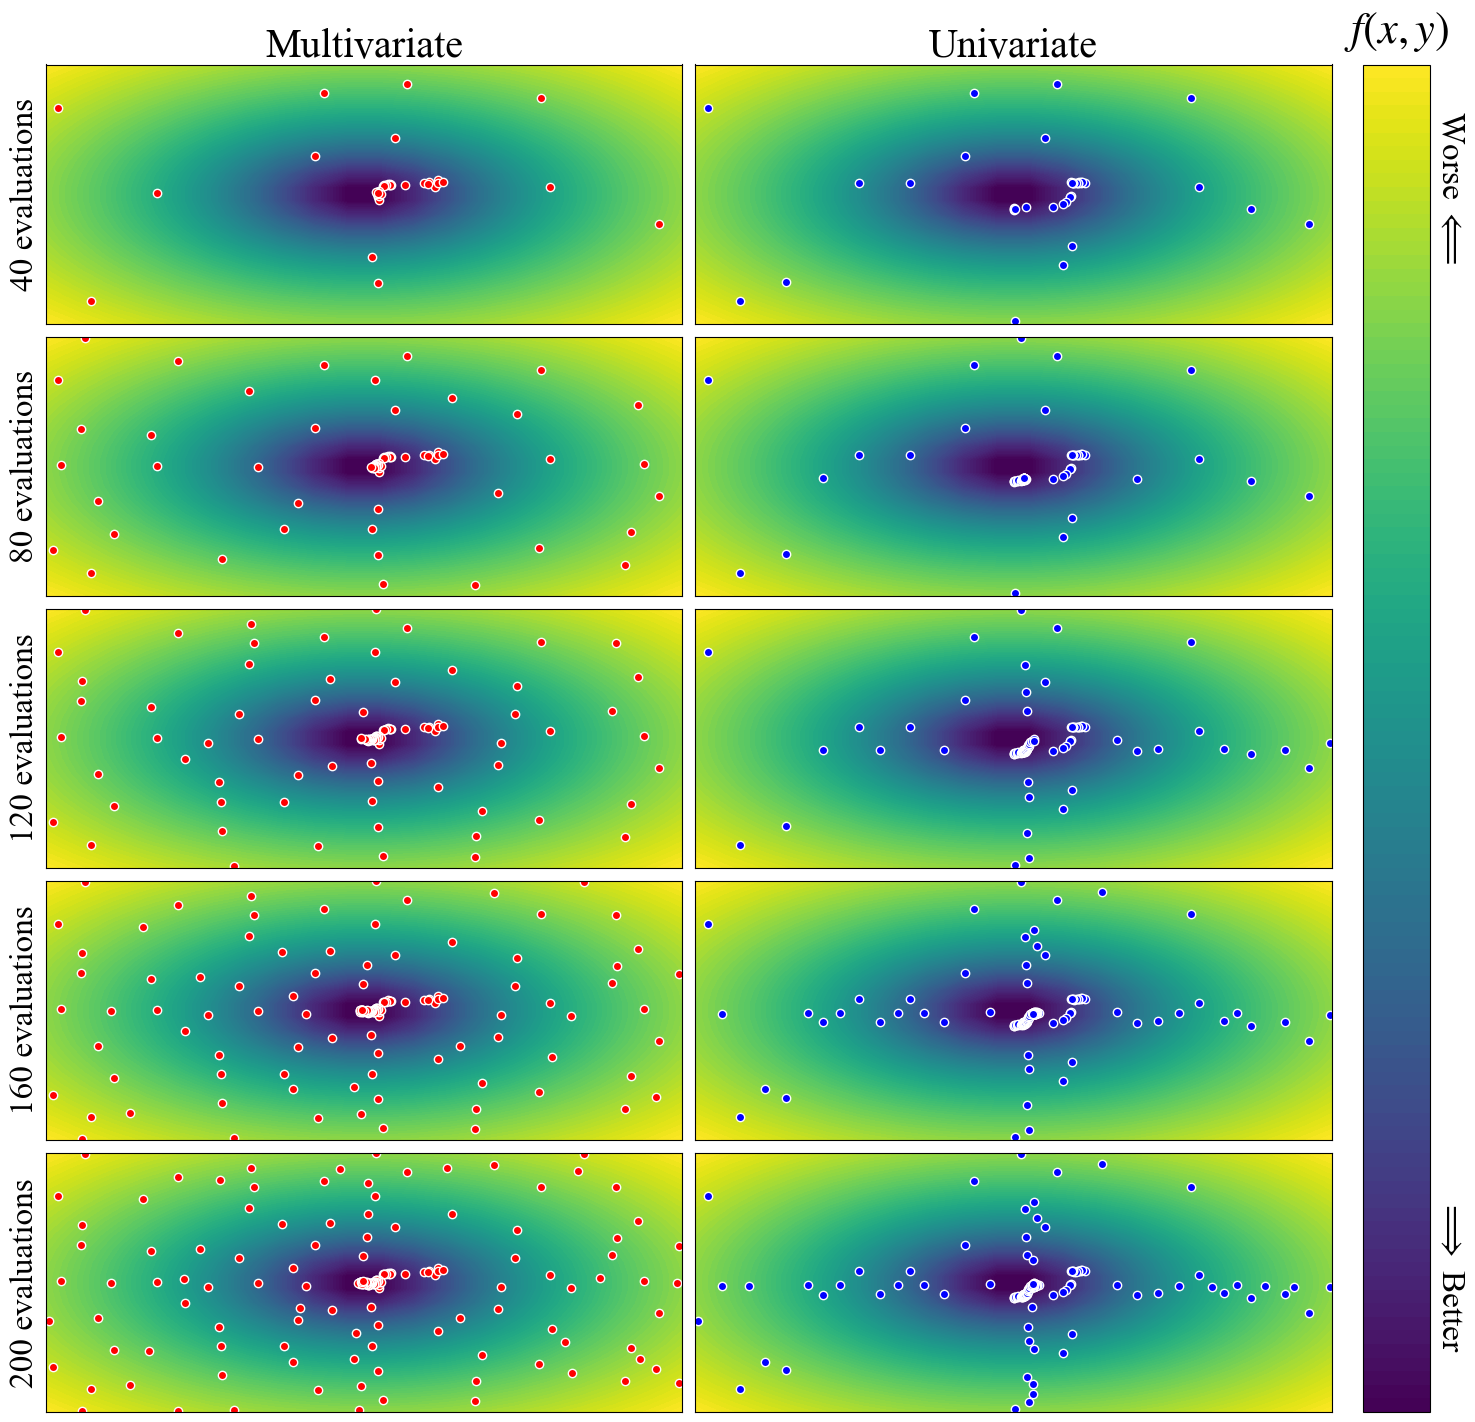

In [15]:
target = Sphere
X, Y = np.meshgrid(np.linspace(-1, 1, 20), np.linspace(-1, 1, 20))
Z = target.func2d(X, Y)
Z -= Z.min() - 1
Z = np.log(Z)
R = 5
n_levels = 100
levels = np.linspace(Z.min(), Z.max(), n_levels)


def add_colorbar(fig, cb, axes):
    cbar = fig.colorbar(cb, ax=axes.ravel().tolist(), pad=0.02)
    cbar.ax.set_title("$f(x, y)$", y=1.01, fontsize=32)
    labels = [""] * n_levels
    labels[-10], labels[10] = "Worse $\Longleftarrow$", "$\Longrightarrow$ Better"
    cbar.set_ticks(levels)
    cbar.set_ticklabels(labels, fontsize=24)
    cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(), rotation=270, va="center")
    # tick目盛りを削除
    cbar.ax.tick_params(size=0)
    return cb


def plot_func(ax):
    ax.tick_params(labelbottom=False, bottom=False, labelleft=False, left=False)
    cb = ax.contourf(X * R, Y * R, Z, levels=levels)
    return cb


config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("x", -1, 1))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter("y", -1, 1))

fixed_kwargs = dict(
    obj_func=target.func,
    config_space=config_space,
    seed=0,
)

max_evals = 200

nrows = 5
fig, axes = plt.subplots(
    ncols=2,
    nrows=nrows,
    figsize=(20, 3.5 * nrows),
    gridspec_kw=dict(
        wspace=0.02,
        hspace=0.05
    )
)

opt_mv = TPEOptimizer(
    max_evals=max_evals,
    multivariate=True,
    **fixed_kwargs,
)
opt_mv.optimize()
opt_uv = TPEOptimizer(
    max_evals=max_evals,
    multivariate=False,
    **fixed_kwargs,
)
opt_uv.optimize()

for r in range(nrows):
    n_evals = 40 * (r + 1)
    ax = axes[r][0]
    if r == 0:
        ax.set_title("Multivariate")
    cb = plot_func(ax)
    results_mv = opt_mv.fetch_observations()
    ax.scatter(results_mv["x"][:n_evals] * R, results_mv["y"][:n_evals] * R, color="red", ec="white")
    ax.set_ylabel(f"{n_evals} evaluations")

    ax = axes[r][1]
    if r == 0:
        ax.set_title("Univariate")

    plot_func(ax)
    results_uv = opt_uv.fetch_observations()
    ax.scatter(results_uv["x"][:n_evals] * R, results_uv["y"][:n_evals] * R, color="blue", ec="white")
else:
    add_colorbar(fig, cb, axes)

plt.savefig("figs/exploration-by-multivariate-in-sphere.pdf", bbox_inches="tight")